In [16]:
from dataloaders import DAS_data_generator
from torch.utils.data import DataLoader
from model import DenoisingUNet
from glob import glob
from utils import *
import os
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Train & Validation sets

In [17]:
file_path = "../data/santorini-DAS-2048-v2"
files = glob(os.path.join(file_path, '*.npy'))
len(files)

17

In [18]:
test_indices = [3,13,16]
val_files = [files[i] for i in test_indices]
train_files = [i for i in files if i not in val_files]
print(f"{len(train_files)} train and {len(val_files)} val files.")

14 train and 3 val files.


In [19]:
train_samples = []
for file in train_files:
    data = np.load(file)
    N_t = data.shape[1]
    t_slice = slice(N_t//4, 3*N_t//4)
    scaled_data = np.zeros_like(data)
    # Loop over data and normalise
    for i, wv in enumerate(data):
        scaled_data[i] = wv / wv[t_slice].std()
    train_samples.append(scaled_data)
train_samples = np.stack(train_samples)

In [20]:
val_samples = []
for file in val_files:
    data = np.load(file)
    N_t = data.shape[1]
    t_slice = slice(N_t//4, 3*N_t//4)
    scaled_data = np.zeros_like(data)
    # Loop over data and normalise
    for i, wv in enumerate(data):
        scaled_data[i] = wv / wv[t_slice].std()
    val_samples.append(scaled_data)
val_samples = np.stack(val_samples)

## Hyperparameters

In [21]:
N_sub = 11
hidden_layers = 4
learning_rate = 5e-4
num_epochs = 200
Nt = 2048
train_batch_size = 32
val_batch_size = 32
train_batch_multiplier = 10
val_batch_multiplier = 10

## Datasets and DataLoaders

In [22]:
train_dataset = DAS_data_generator(train_samples, N_sub=11, batch_size=train_batch_size, batch_multiplier=train_batch_multiplier)
train_loader = DataLoader(train_dataset, batch_size=1, drop_last=True, shuffle=True)

In [23]:
val_dataset = DAS_data_generator(val_samples, N_sub=11, batch_size=val_batch_size, batch_multiplier=val_batch_multiplier)
val_loader = DataLoader(val_dataset, batch_size=1, drop_last=True, shuffle=True)

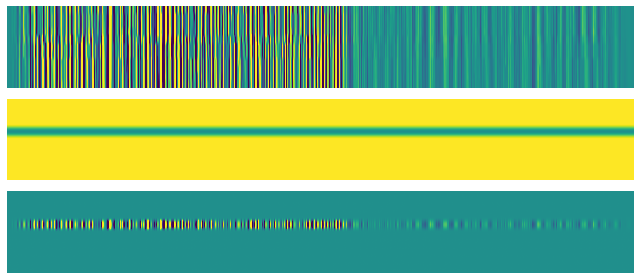

In [24]:
for (samples, masks), masked_samples in train_loader:
    samples = samples[0]
    masks = masks[0]
    masked_samples = masked_samples[0]
    break
# Draw canvas
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))

# Show sample (without blanking)
axes[0].imshow(samples[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[0].axis("off")

# Show mask
axes[1].imshow(masks[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[1].axis("off")

# Show prediction target
axes[2].imshow(masked_samples[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [25]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

# Load model trained at synthetic data
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('..\\data\\runs\\synthetic-run\\final-2000.pth')
model.load_state_dict(state['model_state_dict'])
model.train()
model.to(device)
# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


## Training

In [26]:
epochs_losses_train = []
epochs_losses_val = []
for epoch in range(num_epochs):
    train_loader.dataset.__init__(train_samples, N_sub=11, batch_size=train_batch_size, batch_multiplier=train_batch_multiplier)
    batch_losses = []
    ## TRAIN ##
    model.train()
    for (samples, masks), masked_samples in train_loader:
        samples = samples[0].reshape(train_batch_size,1,N_sub,Nt).float().to(device)
        masks = masks[0].reshape(train_batch_size,1,N_sub,Nt).float().to(device)
        masked_samples = masked_samples[0].reshape(train_batch_size,1,N_sub,Nt).float().to(device)
        # apply mask
        sample = (samples * masks).clone().detach()
        optimizer.zero_grad()
        c_mask = 1-masks
        # apply complementary mask to output (proj. operator)
        output = model(sample)*c_mask
        loss = criterion(output, masked_samples)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    model.eval()
    eval_losses = []
    with torch.no_grad():
        val_loader.dataset.__init__(val_samples, N_sub=11, batch_size=val_batch_size, batch_multiplier=val_batch_multiplier)
        for (samples, masks), masked_samples in val_loader:
            samples = samples[0].reshape(val_batch_size,1,N_sub,Nt).float().to(device)
            masks = masks[0].reshape(val_batch_size,1,N_sub,Nt).float().to(device)
            masked_samples = masked_samples[0].reshape(val_batch_size,1,N_sub,Nt).float().to(device)
            # apply mask
            sample = samples * masks.clone().detach()
            optimizer.zero_grad()
            c_mask = 1-masks
            # apply complementary mask to output (proj. operator)
            output = model(sample)*c_mask
            loss = criterion(output, masked_samples)
            eval_losses.append(loss.item())
        epochs_losses_val.append(np.mean(eval_losses))
    print(f"Epoch: {epoch} Training Loss: {epochs_losses_train[-1]}, Validation Loss: {epochs_losses_val[-1]}")

Epoch: 0 Training Loss: 0.013532007665240339, Validation Loss: 0.009753915457986295
Epoch: 1 Training Loss: 0.0059040006998527265, Validation Loss: 0.008563219546340406
Epoch: 2 Training Loss: 0.00554917516003895, Validation Loss: 0.008545879049537082
Epoch: 3 Training Loss: 0.0053769527843022455, Validation Loss: 0.008613779861479997
Epoch: 4 Training Loss: 0.005241758106941623, Validation Loss: 0.008335868610690038
Epoch: 5 Training Loss: 0.005107286287238821, Validation Loss: 0.008501848625019192
Epoch: 6 Training Loss: 0.005140776667810445, Validation Loss: 0.008342741321151455
Epoch: 7 Training Loss: 0.005047381911260475, Validation Loss: 0.008654435887001455
Epoch: 8 Training Loss: 0.004881536432575168, Validation Loss: 0.008123267294528584
Epoch: 9 Training Loss: 0.005015331125053178, Validation Loss: 0.00840865015828361
Epoch: 10 Training Loss: 0.004975296582727294, Validation Loss: 0.0083286955098932
Epoch: 11 Training Loss: 0.004935264249797911, Validation Loss: 0.00838598581

Text(0.5, 1.0, 'Validation MSE')

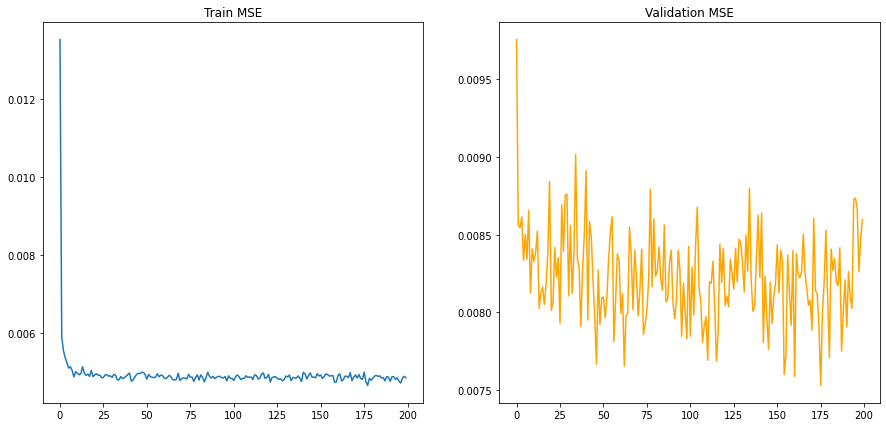

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(epochs_losses_train)
ax1.set_title("Train MSE")
ax2.plot(epochs_losses_val, 'orange')
ax2.set_title("Validation MSE")

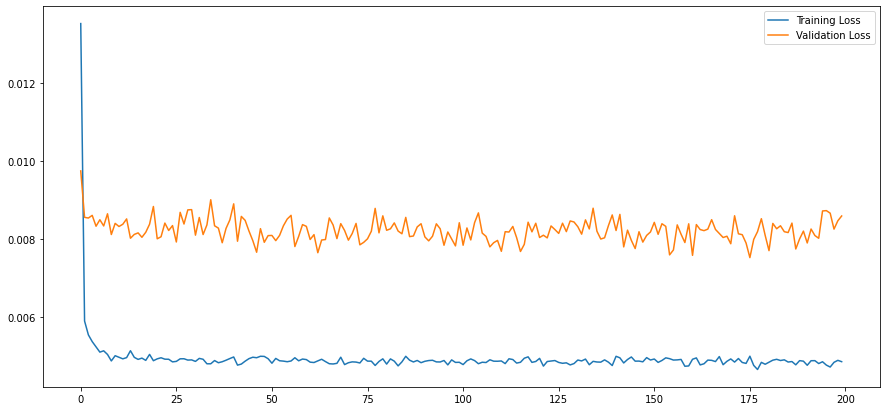

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(epochs_losses_train,label='Training Loss')
ax.plot(epochs_losses_val,label='Validation Loss')
plt.legend()

In [29]:
model_name = "DAS-2-v2"
# save model
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, f"..\\data\\runs\\synthetic-run\\DAS-santorini-2048-v2-runs\\{model_name}.pth")

In [30]:
# save dictionary of hyperparameters as .txt file
hps = {"N_sub":N_sub, "train_batch_size":train_batch_size, "val_batch_size":val_batch_size, 
        "train_batch_multiplier":train_batch_multiplier, "val_batch_multiplier":val_batch_multiplier,
        "learning_rate":learning_rate,"num_epochs":num_epochs,"hidden_layers":hidden_layers}
with open(f"..\\data\\runs\\synthetic-run\\DAS-santorini-2048-v2-runs\\{model_name}.txt", 'w') as file:
     file.write(json.dumps(hps))